# Steps
1. Import data
2. Data Preprocessing: convert data into a `spectogram`
3. Data Splitting: split data into train, dev, and test sets
4. Create Model
5. Train Model
6. Evaluate Results

## Libraries
1. Librosa: Python package for music and audio analysis

In [1]:
# Libraries
!pip install --upgrade tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 588.3 MB 6.4 kB/s 
     |████████████████████████████████| 4.7 MB 49.0 MB/s 
     |████████████████████████████████| 439 kB 63.1 MB/s 
     |████████████████████████████████| 1.7 MB 58.7 MB/s 
     |████████████████████████████████| 6.0 MB 46.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import Data

In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 2s 0us/step


## Check Data

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['right' 'yes' 'left' 'stop' 'up' 'go' 'no' 'down']


## Data Splitting
Using `tf.keras.utils.audio_dataset_from_directory` which do the heavy lifting for us in splitting the data. The output function will be a `tf.data.Dataset` based on the audio files where we can implement parallellization, prefecthing and caching for faster training.

The arguments that we need to provide are:
1. Batch size
2. Validation split
3. Output sequence length: maximum length of audio sequence. If not being set then all audio files will be set to the longest audio sequence and will be zero padded.
4. Subset : subset of data return whether it is 'training', 'validation', and 'both'. 'both' can be run if **validation_split** parameter is set to **True**

In [132]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both',
)

class_names = np.array(train_ds.class_names)
print()
print("class names:", class_names)
print("index label:", np.array(range(len(class_names))))


Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

class names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
index label: [0 1 2 3 4 5 6 7]


In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Since the dataset only contains only a single channels then we can delete the last axis

In [7]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Since the `tf.utils.audio_dataset_from_directory` function only return train and validation sets (two splits). It is a good idea to keep a test set separate and we can do that using the `Dataset.shard`.

In [8]:
# example [0,1,2,3,4,5,6,7,9]
# test_ds = val_ds.shard(num_shards=2, index=0) -> 0, 2, 4, 6, 8
# val_ds = val_ds.shard(num_shards=2, index=1) -> 1, 3, 5, 7, 9
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [9]:
for example_audio, example_labels in train_ds.take(1):
    print("Audio example shape: {}".format(example_audio.shape))
    print("Audio example label: {}".format(example_labels.shape))

Audio example shape: (64, 16000)
Audio example label: (64,)


## Visualize Data

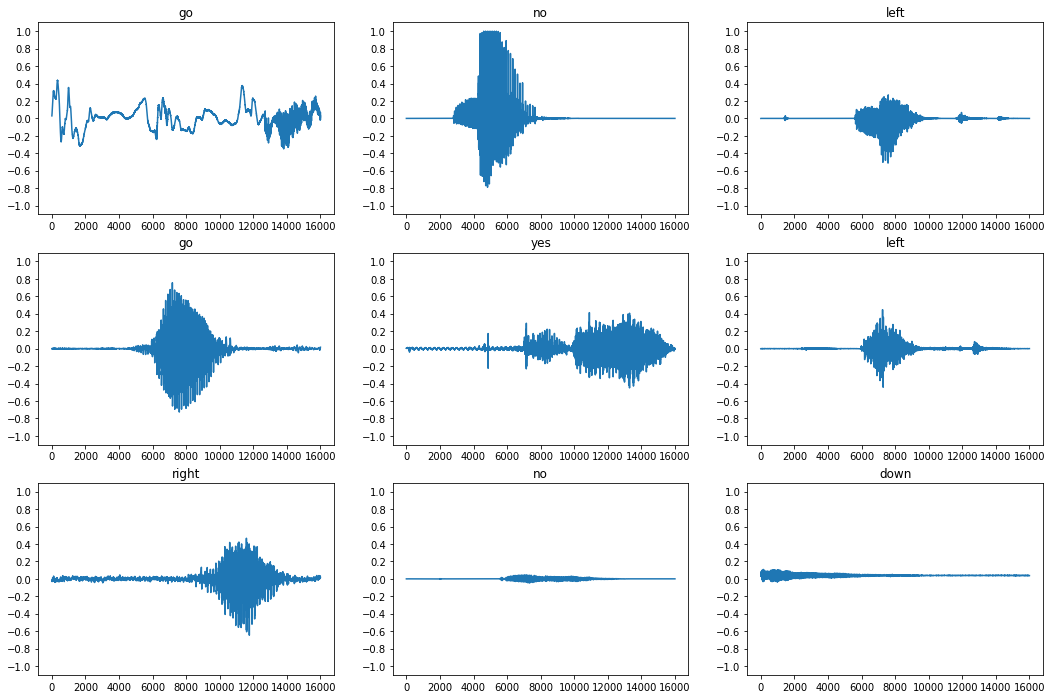

In [10]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))

for i in range(n):
    if i>=n:
        break
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label_names[example_labels[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1,1.1])

plt.show()

## Data Preprocessing
Converting waveforms to **spectograms** (x-axis=time, y-axis=frequency) using **short-time Fourier transform (STFT)**. **Spectograms** which show frequency changes over time and can be represented as 2D images. This spectogram is what will be feed to the neural network model.

A **Fourier transform** (tf.signal.fft) and **STFT** (tf.signal.stft) both converts a signal to its component **frequencies**. The difference is a **Fourier Transform** loses all time information but the **STFT** (**divide the waveforms into multiple windows of time and runs a Fourier Transform** on it) preserving some time information, and returning a 2D tensor that you can run standard convolutions on.
![image.png](https://github.com/marcellinus-witarsah/speech-to-text-model/blob/main/images/spectogram.png?raw=1)

Create a utility function for converting waveforms to spectograms:
1. The waveforms need to be the same length because we want the same length spectogram. If one of the audio waveform length is shorter than the longest length in the data, then it will be padded by 0 filling the remaining length.
2. When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice.
3. The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [11]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128,
    )
    spectrogram=tf.abs(spectrogram)
    spectrogram=spectrogram[..., tf.newaxis]
    return spectrogram

In [12]:
for i in range(3):
    label = commands[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: stop
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Plot spectrogram

In [13]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

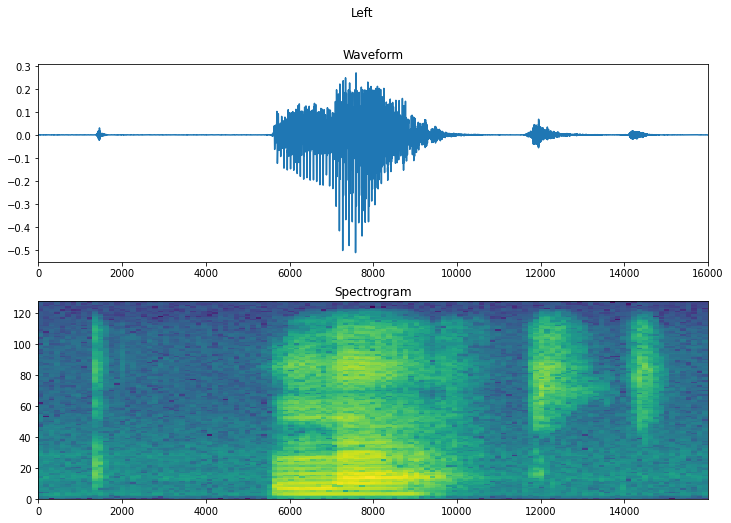

In [14]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Create spectrogram from the audio datasets

In [17]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

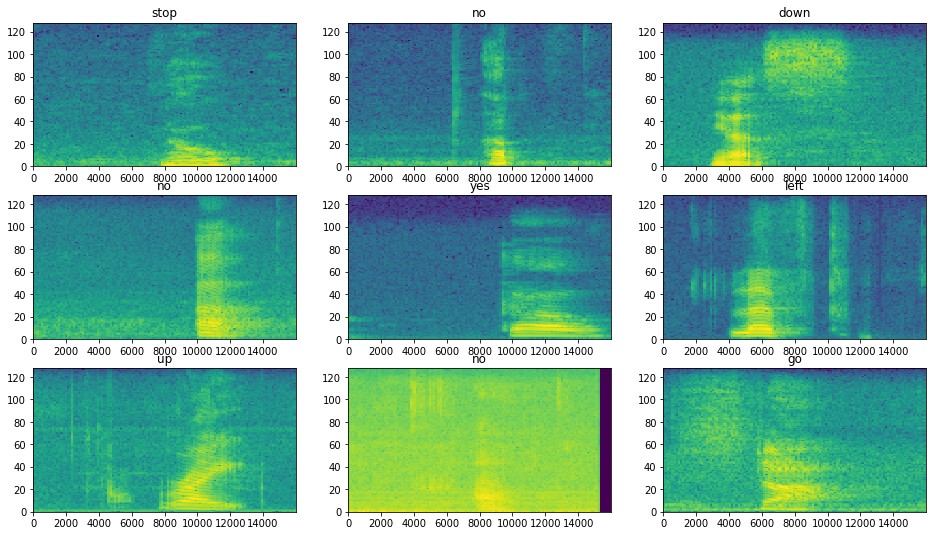

In [19]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

## Create Model

In [176]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [188]:
# Define input shape
input_shape = example_spectrograms.shape[1:]
print("input shape: {}".format(input_shape))
num_labels = len(commands)

# Normalize layer
norm_layer = tf.keras.layers.Normalization()
# Normalizaiton layer according to the data that is available
norm_layer.adapt(data=train_spectrogram_ds.map(lambda spec, label: spec))

# CNN Model
def cnn_model(input_shape):
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        # resize
        tf.keras.layers.Resizing(32, 32),
        # normalize
        norm_layer,
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_labels, activation='softmax')
    ], name='cnn_model')
model = cnn_model(input_shape)
model.summary()

input shape: (124, 129, 1)
Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_19 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_19 (Normaliza  (None, 32, 32, 1)        3         
 tion)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_19 (Flatten)        (

In [189]:
# compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [190]:
EPOCHS = 20
CALLBACKS = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=2,
        verbose=2,
    ),
    tf.keras.callbacks.ModelCheckpoint(
         filepath=model.name, 
         monitor='val_accuracy',
         save_best_only=True,
         mode='max',
         verbose=2,
    ),
]
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=CALLBACKS,
)

Epoch 1/20
 98/100 [============================>.] - ETA: 0s - loss: 1.7750 - accuracy: 0.3487
Epoch 1: val_accuracy improved from -inf to 0.61068, saving model to cnn_model


100/100 [==============================] - 4s 22ms/step - loss: 1.7732 - accuracy: 0.3523 - val_loss: 1.3181 - val_accuracy: 0.6107
Epoch 2/20
 94/100 [===========================>..] - ETA: 0s - loss: 1.2395 - accuracy: 0.5582
Epoch 2: val_accuracy improved from 0.61068 to 0.70443, saving model to cnn_model


100/100 [==============================] - 2s 19ms/step - loss: 1.2314 - accuracy: 0.5622 - val_loss: 0.9701 - val_accuracy: 0.7044
Epoch 3/20
 98/100 [============================>.] - ETA: 0s - loss: 0.9484 - accuracy: 0.6564
Epoch 3: val_accuracy improved from 0.70443 to 0.73307, saving model to cnn_model


100/100 [==============================] - 2s 19ms/step - loss: 0.9477 - accuracy: 0.6558 - val_loss: 0.8104 - val_accuracy: 0.7331
Epoch 4/20
 95/100 [===========================>..] - ETA: 0s - loss: 0.8034 - accuracy: 0.7079
Epoch 4: val_accuracy improved from 0.73307 to 0.79948, saving model to cnn_model


100/100 [==============================] - 2s 18ms/step - loss: 0.8005 - accuracy: 0.7086 - val_loss: 0.6849 - val_accuracy: 0.7995
Epoch 5/20
 95/100 [===========================>..] - ETA: 0s - loss: 0.6790 - accuracy: 0.7632
Epoch 5: val_accuracy did not improve from 0.79948
100/100 [==============================] - 1s 7ms/step - loss: 0.6765 - accuracy: 0.7638 - val_loss: 0.6080 - val_accuracy: 0.7995
Epoch 6/20
 94/100 [===========================>..] - ETA: 0s - loss: 0.6117 - accuracy: 0.7824
Epoch 6: val_accuracy improved from 0.79948 to 0.82552, saving model to cnn_model


100/100 [==============================] - 2s 23ms/step - loss: 0.6102 - accuracy: 0.7816 - val_loss: 0.5643 - val_accuracy: 0.8255
Epoch 7/20
 99/100 [============================>.] - ETA: 0s - loss: 0.5602 - accuracy: 0.8003
Epoch 7: val_accuracy improved from 0.82552 to 0.83464, saving model to cnn_model


100/100 [==============================] - 2s 19ms/step - loss: 0.5594 - accuracy: 0.8006 - val_loss: 0.5250 - val_accuracy: 0.8346
Epoch 8/20
 97/100 [============================>.] - ETA: 0s - loss: 0.5003 - accuracy: 0.8206
Epoch 8: val_accuracy did not improve from 0.83464
100/100 [==============================] - 1s 7ms/step - loss: 0.5016 - accuracy: 0.8200 - val_loss: 0.5014 - val_accuracy: 0.8333
Epoch 9/20
 93/100 [==========================>...] - ETA: 0s - loss: 0.4590 - accuracy: 0.8364
Epoch 9: val_accuracy improved from 0.83464 to 0.85286, saving model to cnn_model


100/100 [==============================] - 2s 18ms/step - loss: 0.4540 - accuracy: 0.8373 - val_loss: 0.4675 - val_accuracy: 0.8529
Epoch 10/20
 95/100 [===========================>..] - ETA: 0s - loss: 0.4258 - accuracy: 0.8469
Epoch 10: val_accuracy improved from 0.85286 to 0.86198, saving model to cnn_model


100/100 [==============================] - 2s 19ms/step - loss: 0.4232 - accuracy: 0.8484 - val_loss: 0.4452 - val_accuracy: 0.8620
Epoch 11/20
100/100 [==============================] - ETA: 0s - loss: 0.3947 - accuracy: 0.8600
Epoch 11: val_accuracy did not improve from 0.86198
100/100 [==============================] - 1s 7ms/step - loss: 0.3947 - accuracy: 0.8600 - val_loss: 0.4617 - val_accuracy: 0.8451
Epoch 12/20
 94/100 [===========================>..] - ETA: 0s - loss: 0.3684 - accuracy: 0.8703
Epoch 12: val_accuracy did not improve from 0.86198
100/100 [==============================] - 1s 7ms/step - loss: 0.3740 - accuracy: 0.8683 - val_loss: 0.4882 - val_accuracy: 0.8398
Epoch 12: early stopping


Plot model training performance

In [191]:
best_model = tf.keras.models.load_model('cnn_model')

Text(0.5, 1.0, 'cnn_model Accuracy vs Validation Accuracy')

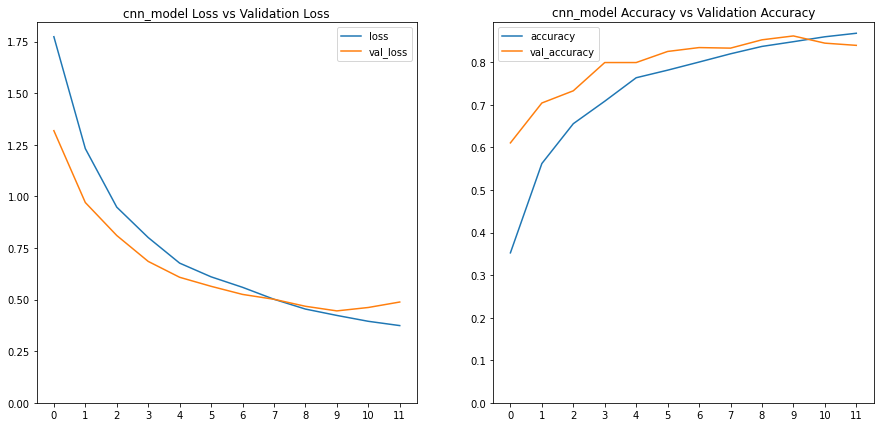

In [192]:
metrics = history.history
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xticks(history.epoch)
plt.title("{} Loss vs Validation Loss".format(history.model.name))
plt.subplot(1,2,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, max(plt.ylim())])
plt.xticks(history.epoch)
plt.title("{} Accuracy vs Validation Accuracy".format(history.model.name))

Evaluate model

In [193]:
best_model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 0s 5ms/step - loss: 0.4690 - accuracy: 0.8353


{'loss': 0.4690118432044983, 'accuracy': 0.8353365659713745}

Create a confussion matrix

In [194]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda spectrogram, label: label)), axis=0)

13/13 [==============================] - 0s 3ms/step


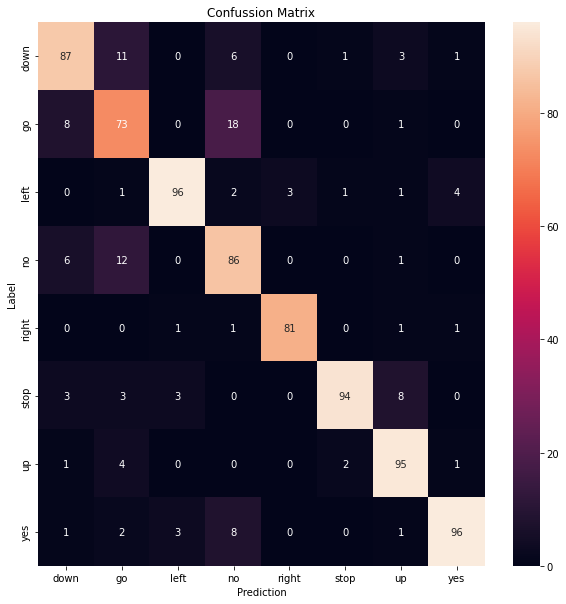

In [195]:
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix, 
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Confussion Matrix')
plt.show()

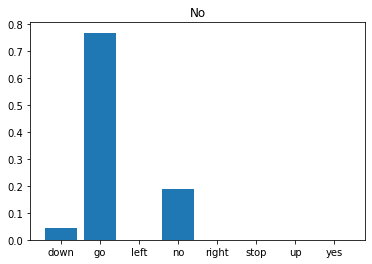

In [202]:
x = data_dir/'go/0132a06d_nohash_2.wav'

# x = data_dir/'no/01bb6a2a_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = best_model(x)
plt.bar(class_names, prediction[0])
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [205]:
!zip -r ./cnn_model.zip ./cnn_model

  adding: cnn_model/ (stored 0%)
  adding: cnn_model/saved_model.pb (deflated 88%)
  adding: cnn_model/variables/ (stored 0%)
  adding: cnn_model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: cnn_model/variables/variables.index (deflated 62%)
  adding: cnn_model/keras_metadata.pb (deflated 90%)
  adding: cnn_model/fingerprint.pb (stored 0%)
  adding: cnn_model/assets/ (stored 0%)
